<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/mini_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps=100):
        super().__init__()
        self.timesteps = timesteps

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Main network
        self.net = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        # Setup noise schedule - using beta schedule instead of alpha directly
        betas = torch.linspace(0.0001, 0.02, timesteps)
        alphas = 1. - betas
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))

    def get_time_embedding(self, t):
        # Convert t to float and reshape
        t_float = t.float().view(-1, 1)
        return self.time_embed(t_float)

    def forward(self, x_noisy, t):
        # Embed time
        #print(t.shape) [128]
        t_emb = self.get_time_embedding(t) #[128, 256]

        # Ensure t_emb has the same batch size as x_noisy
        t_emb = t_emb.expand(x_noisy.shape[0], -1) #[128, 256]

        # Concatenate input with time embedding
        x = torch.cat([x_noisy, t_emb], dim=1) #[128, 1040]
        #print(x_noisy.shape) [128, 784]

        # Predict noise
        return self.net(x)

    def noising_process(self, x, t): #cumprod is equivalent to sequentially adding up gaussian noise for timestep t (the math for it is quite interesting)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        noise = torch.randn_like(x)
        #print(x.shape) [128, 784]
        return (sqrt_alphas_cumprod_t * x +
                sqrt_one_minus_alphas_cumprod_t * noise), noise

    @torch.no_grad()
    def sample(self, n_samples, device):
        # Start with random noise
        x = torch.randn(n_samples, 784).to(device)

        for t in reversed(range(self.timesteps)):
            # Create batch of same timestep
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)

            # Predict noise
            predicted_noise = self(x, t_batch)

            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]

            # Only add noise if we're not in the last step
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise
            ) + torch.sqrt(1 - alpha_t) * noise

        return x

def train_step(model, optimizer, x_real, device):
    optimizer.zero_grad()
    batch_size = x_real.shape[0]

    # Sample random timesteps for each item in the batch
    t = torch.randint(0, model.timesteps, (batch_size,), device=device)

    # Add noise to the real data
    x_noised, noise_added = model.noising_process(x_real, t)

    # Predict the noise
    predicted_noise = model(x_noised, t)

    # Loss is MSE between predicted and actual noise
    loss = F.mse_loss(predicted_noise, noise_added)

    loss.backward()
    optimizer.step()

    return loss.item()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
model = DiffusionModel(input_dim=784, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Setup data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

dataset = MNIST('./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for batch, _ in dataloader:
        batch = batch.view(-1, 784).to(device)
        loss = train_step(model, optimizer, batch, device)
        total_loss += loss
        num_batches += 1

    avg_loss = total_loss / num_batches
    #if epoch % 10 == 0:
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

    # Generate samples
    samples = model.sample(n_samples=16, device=device)
    samples = samples.view(-1, 1, 28, 28)
    print(f"Generated samples shape: {samples.shape}")
    #break

Epoch 0, Average Loss: 1.0024
Generated samples shape: torch.Size([16, 1, 28, 28])
Epoch 1, Average Loss: 0.9953
Generated samples shape: torch.Size([16, 1, 28, 28])
Epoch 2, Average Loss: 0.9864
Generated samples shape: torch.Size([16, 1, 28, 28])
Epoch 3, Average Loss: 0.9769
Generated samples shape: torch.Size([16, 1, 28, 28])
Epoch 4, Average Loss: 0.9688
Generated samples shape: torch.Size([16, 1, 28, 28])


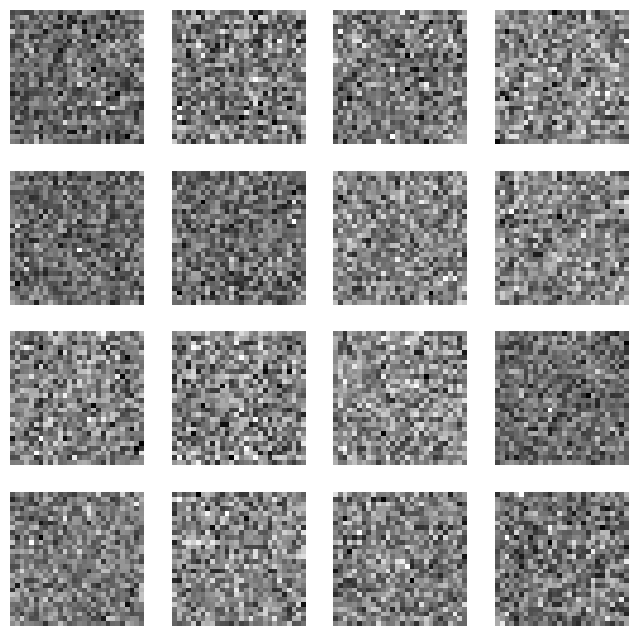

In [12]:
import torch
import matplotlib.pyplot as plt

# Create dummy data for 16 grayscale images of size 28x28
data = torch.randn(16, 1, 28, 28)

# Plot the images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i, 0], cmap='gray')
    ax.axis('off')

plt.show()


In [4]:
print("alphas:", model.alphas.shape)
print("alphas_cumprod:", model.alphas_cumprod.shape)
print("sqrt_alphas_cumprod:", model.sqrt_alphas_cumprod.shape)
print("sqrt_one_minus_alphas_cumprod:", model.sqrt_one_minus_alphas_cumprod.shape)

alphas: torch.Size([100])
alphas_cumprod: torch.Size([100])
sqrt_alphas_cumprod: torch.Size([100])
sqrt_one_minus_alphas_cumprod: torch.Size([100])


In [5]:
batch.shape

torch.Size([96, 784])

In [6]:
%whos


Variable         Type              Data/Info
--------------------------------------------
DataLoader       type              <class 'torch.utils.data.dataloader.DataLoader'>
DiffusionModel   type              <class '__main__.DiffusionModel'>
F                module            <module 'torch.nn.functio<...>/torch/nn/functional.py'>
MNIST            type              <class 'torchvision.datasets.mnist.MNIST'>
avg_loss         float             1.0049076886065225
batch            Tensor            tensor([[-1., -1., -1.,  <...>.,  ..., -1., -1., -1.]])
dataloader       DataLoader        <torch.utils.data.dataloa<...>object at 0x7c30996ed8d0>
dataset          MNIST             Dataset MNIST\n    Number<...>std=(0.5,))\n           )
device           device            cpu
epoch            int               0
loss             float             0.9948086142539978
model            DiffusionModel    DiffusionModel(\n  (time_<...>s=784, bias=True)\n  )\n)
nn               module            <modu